In [1]:
#import necessary libraries 
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import os

In [2]:
#getting the path to the folder 
dir=os.getcwd()

In [3]:
#paths to data
mercury_albedo_top=dir+"/DATA/Data_Mercury/mercury-albedo-top-half.png.csv"
mercury_albedo_bottom=dir+"/DATA/Data_Mercury/mercury-albedo-resized-bottom-half.png.csv"
alsi_map=dir+"/DATA/Data_Mercury/alsimap_smooth_032015.png.csv"
casi_map=dir+"/DATA/Data_Mercury/casimap_smooth_032015.png.csv"
fesi_map=dir+"/DATA/Data_Mercury/fesimap_smooth_032015.png.csv"
mgsi_map=dir+"/DATA/Data_Mercury/mgsimap_smooth_032015.png.csv"
ssi_map=dir+"/DATA/Data_Mercury/ssimap_smooth_032015.png.csv"


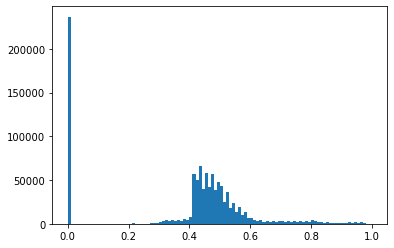

In [16]:
img=np.array(pd.read_csv(ssi_map))
plt.hist(img.flatten(),bins=100)
plt.show()

In [4]:
#custom dataset
class dataset(Dataset):
  def __init__(self,path_1,path_2,path_3,path_4,path_5,path_6):
    self.path_1=path_1
    self.path_2=path_2
    self.path_3=path_3
    self.path_4=path_4
    self.path_5=path_5
    self.path_6=path_6
    #converting the data to tensors
    self.X_1=torch.FloatTensor(np.array(pd.read_csv(path_1)))
    self.X_2=torch.FloatTensor(np.array(pd.read_csv(path_2)))
    self.X_3=torch.FloatTensor(np.array(pd.read_csv(path_3)))
    self.X_4=torch.FloatTensor(np.array(pd.read_csv(path_4)))
    self.X_5=torch.FloatTensor(np.array(pd.read_csv(path_5)))
    self.X_6=torch.FloatTensor(np.array(pd.read_csv(path_6)))
    #normalizing the data
    self.X_1=(self.X_1.flatten()-torch.mean(self.X_1.flatten()))/torch.std(self.X_1.flatten())
    self.X_2=(self.X_2.flatten()-torch.mean(self.X_2.flatten()))/torch.std(self.X_2.flatten())
    self.X_3=(self.X_3.flatten()-torch.mean(self.X_3.flatten()))/torch.std(self.X_3.flatten())
    self.X_4=(self.X_4.flatten()-torch.mean(self.X_4.flatten()))/torch.std(self.X_4.flatten())
    self.X_5=(self.X_5.flatten()-torch.mean(self.X_5.flatten()))/torch.std(self.X_5.flatten())
    self.X_6=self.X_6.flatten()
    self.Y=torch.stack((self.X_1,self.X_2,self.X_3,self.X_4,self.X_5),1)  
    self.X=self.X_6
  
  def __len__(self):
    self.filelength=len(self.Y)
    return self.filelength

  def __getitem__(self,idx):
    return self.X[idx],self.Y[idx]

In [ ]:
class dataset_nearby_pixel(Dataset):
    def __init__(self,path_1,path_2,path_3,path_4,path_5,mode):
        self.path_1=path_1
        self.path_2=path_2
        self.path_3=path_3
        self.path_4=path_4
        self.path_5=path_5
        self.mode=mode
        #converting the data to ndarray
        self.X_1=np.array(pd.read_csv(path_1))
        self.X_2=np.array(pd.read_csv(path_2))
        self.X_3=np.array(pd.read_csv(path_3))
        self.X_4=np.array(pd.read_csv(path_4))
        self.X_5=cv2.GaussianBlur(np.array(pd.read_csv(path_5)),ksize=(0,0),sigmaX=9)
        self.X=[]
        self.Y=[]
        n,m=np.shape(self.X_5)[0],np.shape(self.X_5)[1]
        for i in range(1,n-1):
            for j in range(1,m-1):
                nearby=[]
                for chem in [self.X_1,self.X_2,self.X_3,self.X_4]:
                    for a in [-1,0,1]:
                        for b in [-1,0,1]:
                            nearby.append(chem[i+a][j+b])
                self.X.append(nearby)
                self.Y.append([self.X_5[i][j]])
        l=len(self.Y)//2
        if mode == "Train" or "train":
            self.X=np.array(self.X)[:l]
            self.Y=np.array(self.Y)[:l]
        elif mode== "Test" or "test":
            self.X=np.array(self.X)[l:]
            self.Y=np.array(self.Y)[l:]
    def __len__(self):
        self.filelength=np.shape(self.Y)[0]
        return self.filelength

    def __getitem__(self,idx):
        return torch.from_numpy(self.X[idx]),torch.from_numpy(self.Y[idx])